# TEAM NAME ETC

# Overview

Our task is to build an inferential linear regression model. Our model will help Opendoor make more accurate offers in accordance with their valuation process. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

# Business Understanding

Our stakeholder is Opendoor. Opendoor makes cash offers for homes and resells them. They perform repairs on the home if necessary. They also offer a listing service. They make their profits from fees, not from buying low and selling high. We will be assisting this company in the King County, Washington area. The county seat is Seattle.

The Opendoor process begins with evaluations of a home through photos, listed upgrades, and listed amenities. Next, they find comparable homes or 'comps' to provide a base range. Next, they make adjustments to the offer based on differences between comps. These differences can include features or neighborhood trends. Lastly, they make an offer and send someone to inspect the home.

Our job is to analyze the King County data set and provide solid valuation models that can assist with finding comp valuations, and then detailing the needed adjustments. Different markets have slight differences, and we will report on the most important parameters when assessing home values in the King County area. Since they also do repairs, we will also look at factors that assess the condition and amount of repairs likely needed in the property. Opendoor will be able to use our recommendations to make fair offers in the King County area.

# Data Understanding

The data that we used is King County House Sales data from the King County assessor website. Our data set includes info about homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside the realm of what our stakeholder purchases. This included homes with a price over $1,400,000, homes built before 1930, and homes with a lot size above 2 acres (87,120 square feet).

## *Loading our data*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Keep price < 1400000
df = df[df['price']<=1400000]
#Keep yr built above 1930
df = df[df['yr_built']>1930]
#Delete bedroom >15 typo
df.drop(df[df['bedrooms']>15].index, inplace=True)
#Keep lots under 2 acres or 87120 sqft
df = df[df['sqft_lot']<=87120]

In [5]:
df.shape

(17867, 21)

## Column formatting & Dealing with missing values

### *Renovated < 10 yrs*

In [6]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['renovated_less_10yrs'] = df['yr_renovated'] > 2010.0
df['renovated_less_10yrs'] = df['renovated_less_10yrs'].astype('int64')

### *Condition Column*

In [7]:
df['condition'].replace('Poor', '1', inplace=True)
df['condition'].replace('Fair', '2', inplace=True)
df['condition'].replace('Average', '3', inplace=True)
df['condition'].replace('Good', '4', inplace=True)
df['condition'].replace('Very Good', '5', inplace=True)
df['condition'] = df['condition'].astype(np.int64)

### *View Column*

In [8]:
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

### *Sqft Basement Column*

In [9]:
df['sqft_basement'].replace(to_replace='?', value='0', inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')
df['has_basement'] = df['sqft_basement']
df.loc[df.has_basement > 0, 'has_basement'] = 1

### *Date Column*

In [10]:
# Converting to Datetime
df['date'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

### *Waterfront Column*

In [11]:
# Converting Waterfront to Binary
df['waterfront'] = df['waterfront'].fillna('0')
df['waterfront'].replace(to_replace='NO', value='0', inplace=True)
df['waterfront'].replace(to_replace='YES', value='1', inplace=True)
df['waterfront'] = pd.to_numeric(df['waterfront'],errors='coerce')

### *Grade Column*

In [12]:
# Converting Grade to Numeric
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

In [13]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(17867, 23)
id                               int64
date                    datetime64[ns]
price                          float64
bedrooms                         int64
bathrooms                      float64
sqft_living                      int64
sqft_lot                         int64
floors                         float64
waterfront                       int64
view                             int64
condition                        int64
grade                            int64
sqft_above                       int64
sqft_basement                  float64
yr_built                         int64
yr_renovated                   float64
zipcode                          int64
lat                            float64
long                           float64
sqft_living15                    int64
sqft_lot15                       int64
renovated_less_10yrs             int64
has_basement                   float64
dtype: object
['id' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'wate

# Modeling

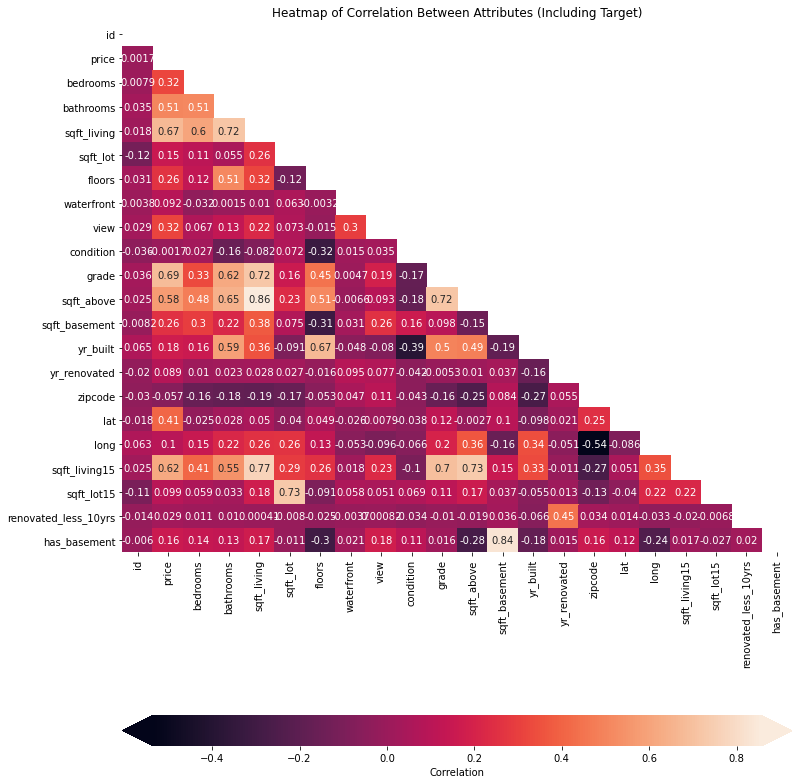

In [14]:
# heatmap_data = pd.concat([y_train, X_train], axis=1)
# corr = heatmap_data.corr()
corr = df.corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

## Baseline Model

In [15]:
#create mean_price col
df['mean_price'] = df['price'].mean()
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated_less_10yrs',
       'has_basement', 'mean_price'],
      dtype='object')

In [16]:
baseline_y = df['price'].mean()
baseline_x = df.drop('price', axis=1)

In [17]:
baseline_y = df['price']
baseline_x = df['mean_price']
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_x, baseline_y, random_state=42)

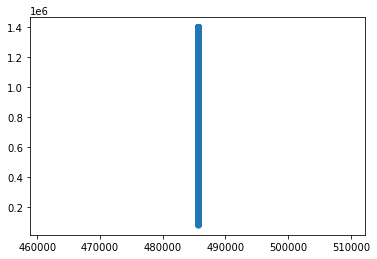

In [18]:
fig, ax = plt.subplots()
ax.scatter(baseline_X_train, baseline_y_train, alpha=0.5);

In [19]:
#OLS chart
baseline_formula = 'baseline_y ~ baseline_x'
baseline_model = ols(baseline_formula, df).fit()
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             baseline_y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 04 Oct 2021   Prob (F-statistic):                nan
Time:                        22:12:44   Log-Likelihood:            -2.4649e+05
No. Observations:               17867   AIC:                         4.930e+05
Df Residuals:                   17866   BIC:                         4.930e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.06e-06   7.53e-09    273.491      0.000    2.04e-06    2.07e-06
baseline_x     1.0000      0.004    273.491      0.000       0.993       1.007
==============================================================================
Omnibus:                     3396.081   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6073.609
Skew:                           1.214   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                     1.55e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
#dropping mean_price col after baseline done
df = df.drop('mean_price', axis=1)

## First Model: Square Feet Living & Price

In [21]:
y = df["price"]
X = df.drop("price", axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

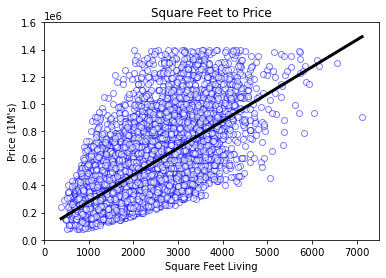

In [142]:
most_correlated_feature = X_train['sqft_living']
fig, ax = plt.subplots()
ax.scatter(most_correlated_feature, y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
ax.set_xlim([0, 7500])
ax.set_ylim([0, 1600000])
plt.plot(np.unique(most_correlated_feature), np.poly1d(np.polyfit(most_correlated_feature, y_train, 1))
         (np.unique(most_correlated_feature)),linewidth=3.0,color='black');

In [24]:
first_formula = 'price ~ sqft_living'
first_model = ols(first_formula, df).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                 1.488e+04
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:12:45   Log-Likelihood:            -2.4108e+05
No. Observations:               17867   AIC:                         4.822e+05
Df Residuals:                   17865   BIC:                         4.822e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.226e+04   3556.507     23.131      0.000    7.53e+04    8.92e+04
sqft_living   197.2792      1.617    121.991      0.000     194.109     200.449
==============================================================================
Omnibus:                     2377.288   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4429.685
Skew:                           0.860   Prob(JB):                         0.00
Kurtosis:                       4.731   Cond. No.                     5.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Second Model

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [148]:
second_formula = 'price ~ sqft_living + grade + condition'
second_model = ols(second_formula, df).fit()
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     7256.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:12:59   Log-Likelihood:            -2.3937e+05
No. Observations:               17867   AIC:                         4.788e+05
Df Residuals:                   17863   BIC:                         4.788e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.259e+05    1.3e+04    -48.298      0.000   -6.51e+05   -6.01e+05
sqft_living   105.1423      2.138     49.169      0.000     100.951     109.334
grade        9.904e+04   1641.022     60.354      0.000    9.58e+04    1.02e+05
condition    4.111e+04   1989.035     20.668      0.000    3.72e+04     4.5e+04
==============================================================================
Omnibus:                     2657.884   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5651.654
Skew:                           0.895   Prob(JB):                         0.00
Kurtosis:                       5.094   Cond. No.                     2.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

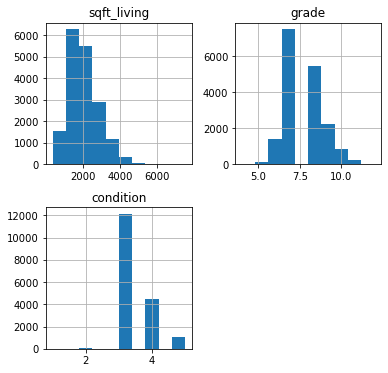

In [149]:
df[['sqft_living', 'grade', 'condition']].hist(figsize  = [6, 6]); 

### *Video Code for RMSE*

In [ ]:
y_pred = baseline_y_train.mean()
y_pred

In [ ]:
y_pred2 = [y_pred]*len(baseline_y_train)

In [ ]:
# mean_abs_e = mean_absolute_error(baseline_y_train, y_pred2)
# mean_abs_e

In [ ]:
mean_sq_e = mean_squared_error(baseline_y_train, y_pred2)
mean_sq_e


In [ ]:
root_means_e = math.sqrt(mean_sq_e)
root_means_e

In [ ]:
y_pred3 = [y_pred] * len(baseline_y_test)
# mae = mean_absolute_error(baseline_y_test, y_pred3)
rmse = (mean_squared_error(baseline_y_test, y_pred3))**0.5
print(f'rmse: {rmse}')

## All variables except id and date

In [ ]:
X_train.info()

In [ ]:
df1 = df.drop('date', axis=1)
df1 = df1.drop('id', axis=1)
y = df1["price"]
X = df1.drop("price", axis=1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train.info()

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
cross_val_score(model, X_train, y_train, cv=3)

In [ ]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

## Second Model

# Regression Results

# Conclusion